# Bank Customer Churn Prediction with classification models
*Author: Fernando Corcuera*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import scipy.stats as ss

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

# First we define some functions:

In [4]:

def univariate_analysis(df, variables):
    results = []

    for var in variables:
        variable = df[var]
        mean = variable.mean()
        median = variable.median()
        std = variable.std()
        stats = {
            'Variable': var,
            'Mean': round(mean, 3),
            'Median': round(median, 3),
            'Sd': round(std, 3),
            'CV (mean)': round(std / mean, 3) if mean != 0 else np.nan,
            'CV (median)': round(std / median, 3) if median != 0 else np.nan,
            'Skewness': round(ss.skew(variable), 3),
            'Kurtosis': round(ss.kurtosis(variable), 3),
            'Min': round(variable.min(), 3),
            'Max': round(variable.max(), 3),
            'Range': round(variable.max() - variable.min(), 3)
        }
        results.append(stats)

    return pd.DataFrame(results)


#pipeline para histogramas
def plot_histograms(df, variables, bins=30, figsize=(18, 10), color='steelblue'):
    """
    Plots a grid of histograms with KDE for the specified variables.

    Parameters:
    df : pd.DataFrame
        The dataset containing the variables.
    variables : list of str
        The list of column names to plot.
    bins : int
        Number of bins for the histogram.
    figsize : tuple
        Size of the entire figure.
    color : str
        Color of the histograms.
    """
    n = len(variables)
    rows = (n + 2) // 3  # ajusta la cantidad de filas si hay más de 6 variables

    plt.figure(figsize=figsize)

    for i, var in enumerate(variables):
        plt.subplot(rows, 3, i+1)
        sns.histplot(df[var], kde=True, bins=bins, color=color)
        plt.title(f'Distribution of {var}')
        plt.xlabel('')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def categorical_univariate_analysis(df, categorical_vars):
    """
    Muestra el conteo absoluto y relativo (%) para cada variable categórica en la lista dada.
    """
    results = {}

    for var in categorical_vars:
        freq = df[var].value_counts()
        perc = df[var].value_counts(normalize=True) * 100
        result = pd.DataFrame({'Frecuencia': freq, 'Porcentaje (%)': round(perc, 2)})
        results[var] = result
        print(f"\n🔹 Distribución de {var}:\n")
        display(result)

    return results

    import matplotlib.pyplot as plt
import seaborn as sns

def plot_boxplots(df, variables, figsize=(18, 10), color='salmon'):
    """
    Plots a grid of boxplots for the specified numerical variables.

    Parameters:
    df : pd.DataFrame
        The dataset containing the variables.
    variables : list of str
        The list of numerical column names to plot.
    figsize : tuple
        Size of the entire figure.
    color : str
        Color of the boxplots.
    """
    n = len(variables)
    rows = (n + 2) // 3  # ajusta para mostrar 3 columnas por fila

    plt.figure(figsize=figsize)

    for i, var in enumerate(variables):
        plt.subplot(rows, 3, i+1)
        sns.boxplot(y=df[var], color=color)
        plt.title(f'Boxplot of {var}')
        plt.xlabel('')
        plt.ylabel(var)

    plt.tight_layout()
    plt.show()

def plot_categorical_distributions(df, categorical_vars, n_cols=3, figsize=(18, 10), color='skyblue'):
    """
    Plots bar plots for a list of categorical variables.

    Parameters:
    df : pd.DataFrame
        The dataset containing the variables.
    categorical_vars : list
        List of column names (categorical variables).
    n_cols : int
        Number of columns in the grid.
    figsize : tuple
        Size of the entire figure.
    color : str
        Color of the bars.
    """
    n = len(categorical_vars)
    n_rows = (n + n_cols - 1) // n_cols  # ceil division

    plt.figure(figsize=figsize)

    for i, var in enumerate(categorical_vars):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.countplot(data=df, x=var, color=color)
        plt.title(f'Distribution of {var}')
        plt.xticks(rotation=45)
        plt.xlabel('')
        plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

# 1. Exploratory Analysis

In [6]:
df = pd.read_csv('/content/Churn_Modelling.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [7]:
churn_rate = df['Exited'].mean() * 100
print(f"Churn rate: {churn_rate:.2f}%")

Churn rate: 20.37%


In [ ]:
churn_clients = df[df['Exited'] == 1]
churn_30_60 = churn_clients[(churn_clients['Age'] >= 30) & (churn_clients['Age'] <= 60)]
total_churn = churn_clients.shape[0]
churn_30_60_count = churn_30_60.shape[0]

# percentage
percentage_30_60 = (churn_30_60_count / total_churn) * 100

print(f"Número de clientes que abandonaron el banco entre 30 y 60 años: {churn_30_60_count}")
print(f"Porcentaje respecto al total de churn: {percentage_30_60:.2f}%")

Número de clientes que abandonaron el banco entre 30 y 60 años: 1798
Porcentaje respecto al total de churn: 88.27%


In [ ]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
df.isnull().sum()

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


## 1.1. Continuous variables:

In [ ]:
c_variables = [
    'CreditScore', 'Age', 'Tenure', 'Balance',
    'NumOfProducts','EstimatedSalary']

# Univariate analysis of continue variables:
continue_uanalysis = univariate_analysis(df, c_variables)

pd.set_option('display.float_format', lambda x: '%.2f' % x)
continue_uanalysis

,Variable,Mean,Median,Sd,CV (mean),CV (median),Skewness,Kurtosis,Min,Max,Range
0,CreditScore,650.53,652.00,96.65,0.15,0.15,-0.07,-0.43,350.00,850.00,500.00
1,Age,38.92,37.00,10.49,0.27,0.28,1.01,1.39,18.00,92.00,74.00
2,Tenure,5.01,5.00,2.89,0.58,0.58,0.01,-1.17,0.00,10.00,10.00
3,Balance,76485.89,97198.54,62397.40,0.82,0.64,-0.14,-1.49,0.00,250898.09,250898.09
4,NumOfProducts,1.53,1.00,0.58,0.38,0.58,0.74,0.58,1.00,4.00,3.00
5,EstimatedSalary,100090.24,100193.91,57510.49,0.57,0.57,0.00,-1.18,11.58,199992.48,199980.90


###Insights del Análisis Univariado

- **Balance:**  
  Media de 76,486 y desviación estándar de 62,397, lo que indica **alta dispersión**.  
  Skewness levemente negativa (-0.14) y kurtosis negativa (-1.48) → distribución **ligeramente asimétrica a la izquierda**, con colas más delgadas que una normal.  
  Tiene valores en 0 → podrían ser **clientes sin fondos**, relevantes para predecir churn.

- **Age:**  
  Promedio de 38.9 años, **skewness positiva** (1.01) y **kurtosis alta** (1.39).  
  Distribución sesgada hacia clientes jóvenes, pero con una cola larga hacia adultos mayores.  
  Rango de 18 a 92 años → podría **segmentarse en grupos etarios** (jóvenes, adultos, seniors) para análisis de churn.

- **NumOfProducts:**  
  Media de 1.53 y mediana de 1 → la mayoría tiene solo **1 o 2 productos**.  
  Skewness positiva (0.74) sugiere que **pocos clientes tienen 3 o más productos**.  
  Puede usarse para medir **profundidad de relación** o lealtad.

- **CreditScore:**  
  Distribución **bastante simétrica y estable** (skew ≈ 0, CV ≈ 0.15).  
  Rango entre 350 y 850. No se observan extremos → es una **variable limpia y lista para modelar**.

- **EstimatedSalary:**  
  Media cercana a 100,000, pero con un rango **muy amplio** (de 11.5 a 199,992).  
  No presenta sesgo relevante → aunque por su dispersión puede **requerir normalización o escalado** si se usa con modelos sensibles a magnitudes.

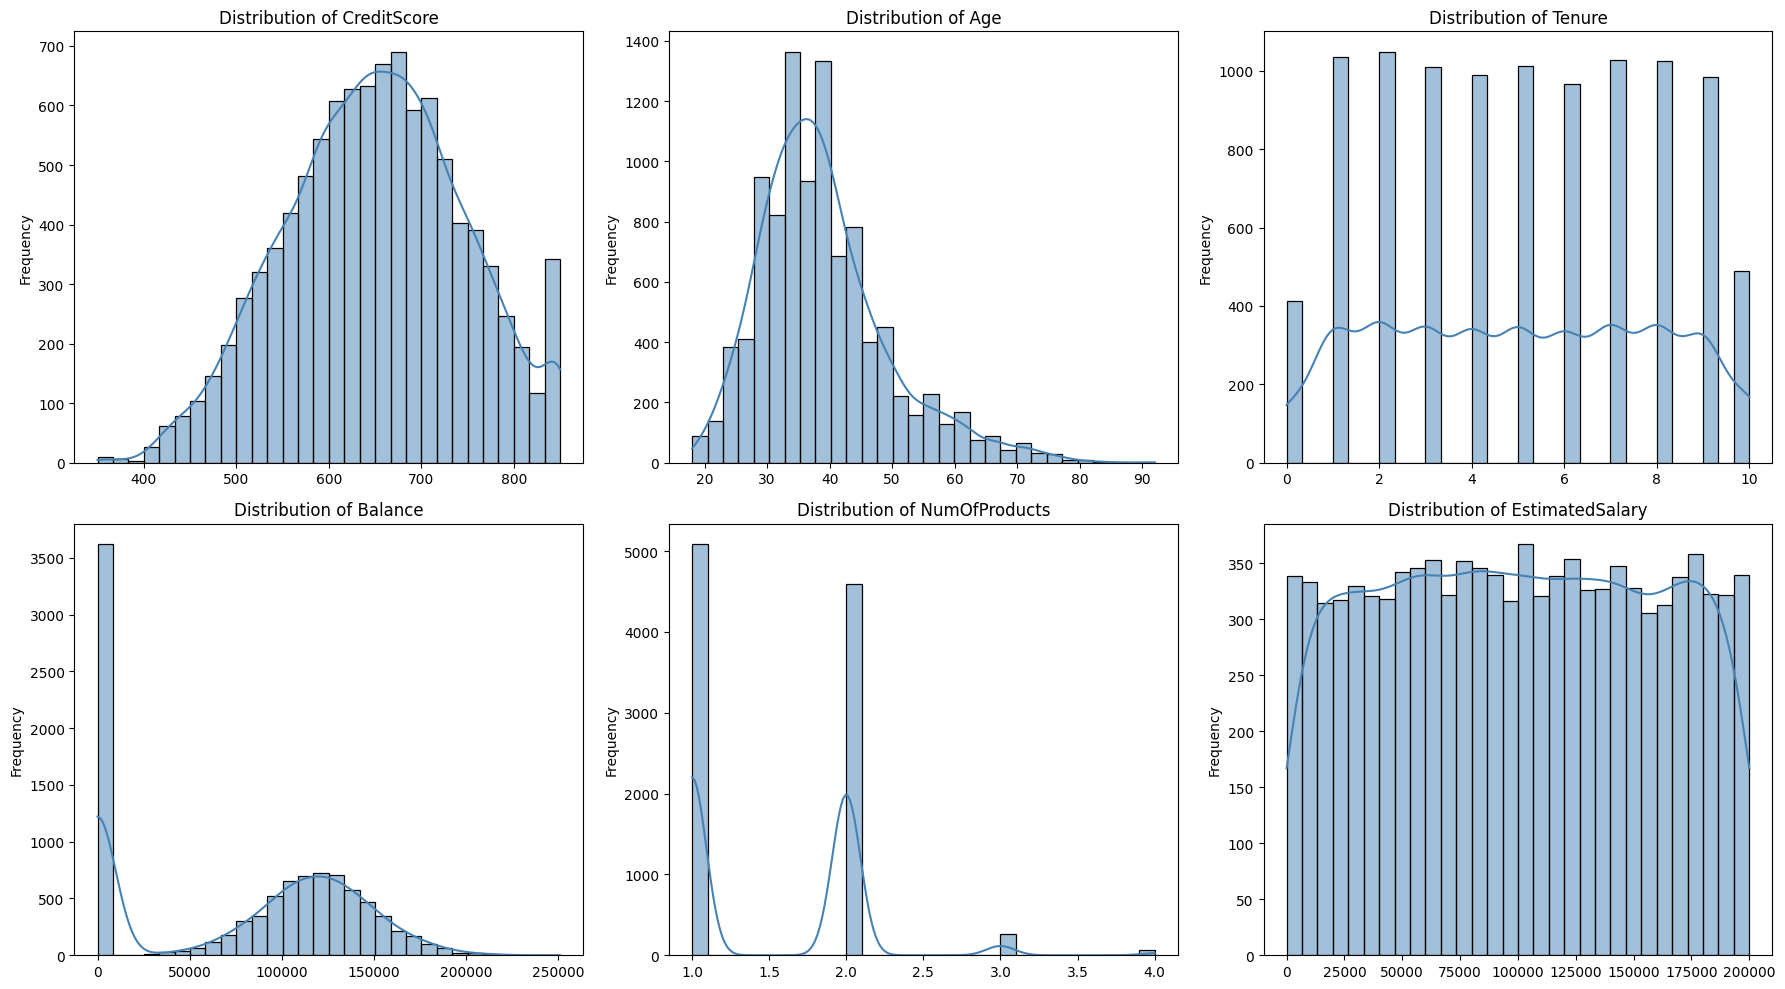

In [ ]:
plot_histograms(df, c_variables)

### 📈 Insights de Distribuciones Visuales

- **CreditScore:**  
  Distribución ligeramente normal con leve asimetría a la izquierda. No hay grandes outliers.

- **Age:**  
  Distribución claramente **asimétrica a la derecha**. La mayoría de clientes están en el rango de 30 a 40 años, pero hay una cola larga hacia mayores de 60.

- **Tenure:**  
  Se distribuye casi uniforme, pero **con picos artificiales**. Esto indica que es una variable categórica disfrazada de numérica (representa años de permanencia, del 0 al 10).

- **Balance:**  
  Altamente sesgada a la derecha. Un número significativo de clientes tiene **balance igual a 0**, lo cual podría ser un predictor directo de churn. El resto tiene una distribución tipo normal.

- **NumOfProducts:**  
  Altamente concentrada en 1 y 2 productos. Los valores de 3 y 4 son muy escasos → posiblemente **outliers o segmentos premium**.

- **EstimatedSalary:**  
  Distribución uniforme E

## Outliers detection

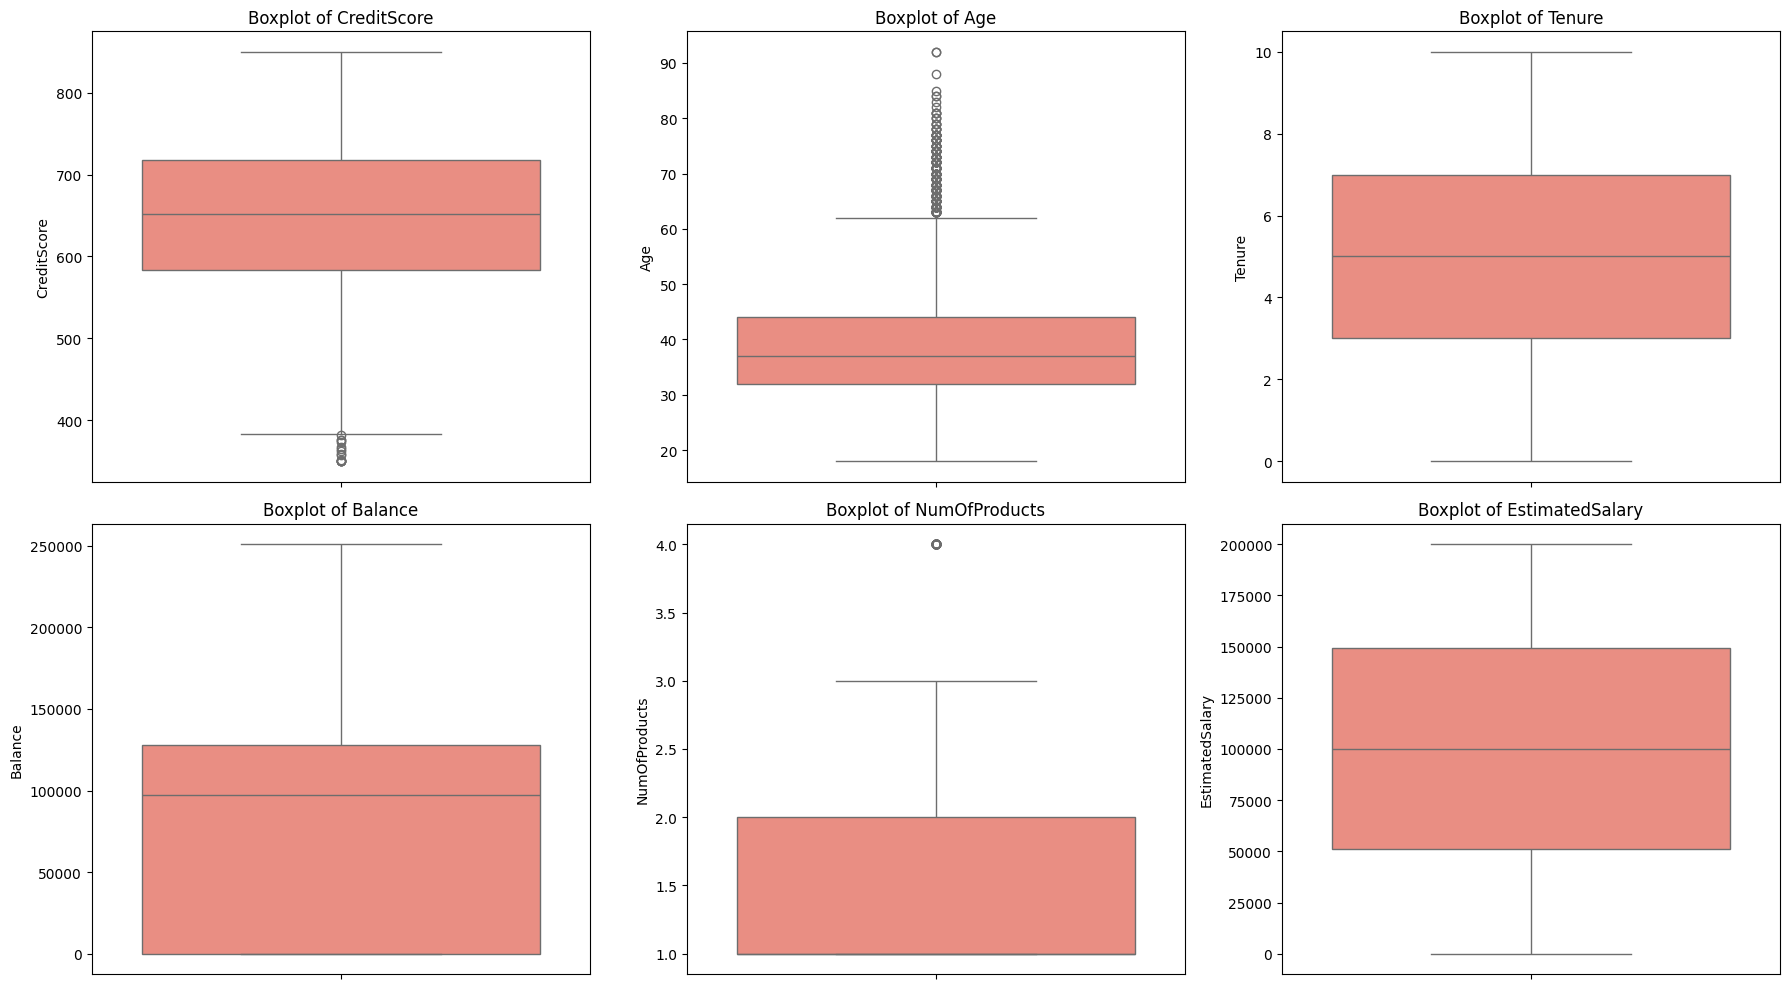

In [ ]:
numeric_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
plot_boxplots(df, numeric_vars)

In [ ]:
import numpy as np

Q1 = df['Age'].quantile(0.25)
Q3 = df['Age'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar outliers
outliers = df[(df['Age'] < lower_bound) | (df['Age'] > upper_bound)]
percentage = len(outliers) / len(df) * 100

print(f"Number of outliers in Age: {len(outliers)}")
print(f"Proportion of the total: {percentage:.2f}%")

Number of outliers in Aage: 359
Proportion of the total: 3.59%


In [ ]:
outliers_churn = outliers['Exited'].sum()
print(f"Clients who made churn within the outliers: {outliers_churn}")

Clients who made churn within the outliers: 73


In [ ]:
# Cálculo de IQR y límites
Q1_cs = df['CreditScore'].quantile(0.25)
Q3_cs = df['CreditScore'].quantile(0.75)
IQR_cs = Q3_cs - Q1_cs

lower_bound_cs = Q1_cs - 1.5 * IQR_cs
upper_bound_cs = Q3_cs + 1.5 * IQR_cs

# Filtrar outliers
outliers_cs = df[(df['CreditScore'] < lower_bound_cs) | (df['CreditScore'] > upper_bound_cs)]
percentage_cs = len(outliers_cs) / len(df) * 100

print(f"Number of outliers in creditscore: {len(outliers_cs)}")
print(f"Percentage of the total: {percentage_cs:.2f}%")

Number of outliers in creditscore: 15
Percentage of the total: 0.15%


In [ ]:
outliers_cs_churn = outliers_cs['Exited'].sum()
print(f"Clients who made churn within the outlieres of CreditScore: {outliers_cs_churn}")

Clients who made churn within the outlieres of CreditScore: 15


# 1.2 Categoric variables

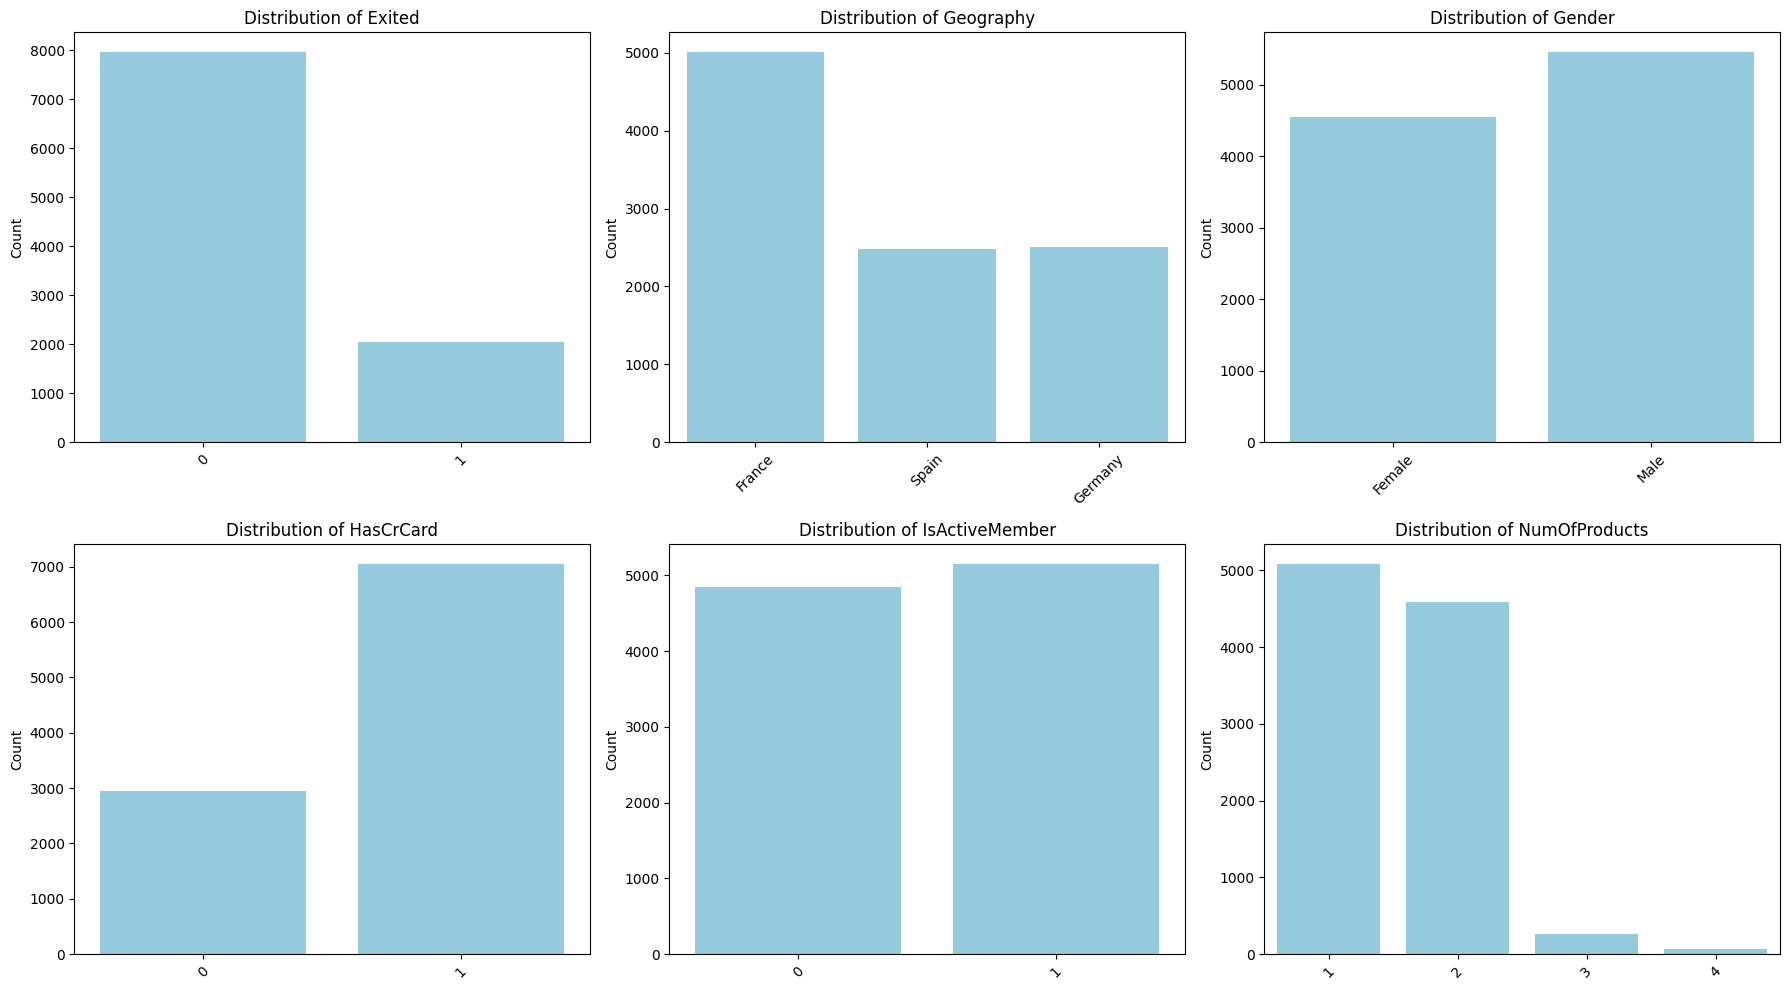

In [ ]:


# Definir variables categóricas
categorical_vars = ['Exited','Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']

# Ejecutar función
plot_categorical_distributions(df, categorical_vars)

##Bivariate Analaysis

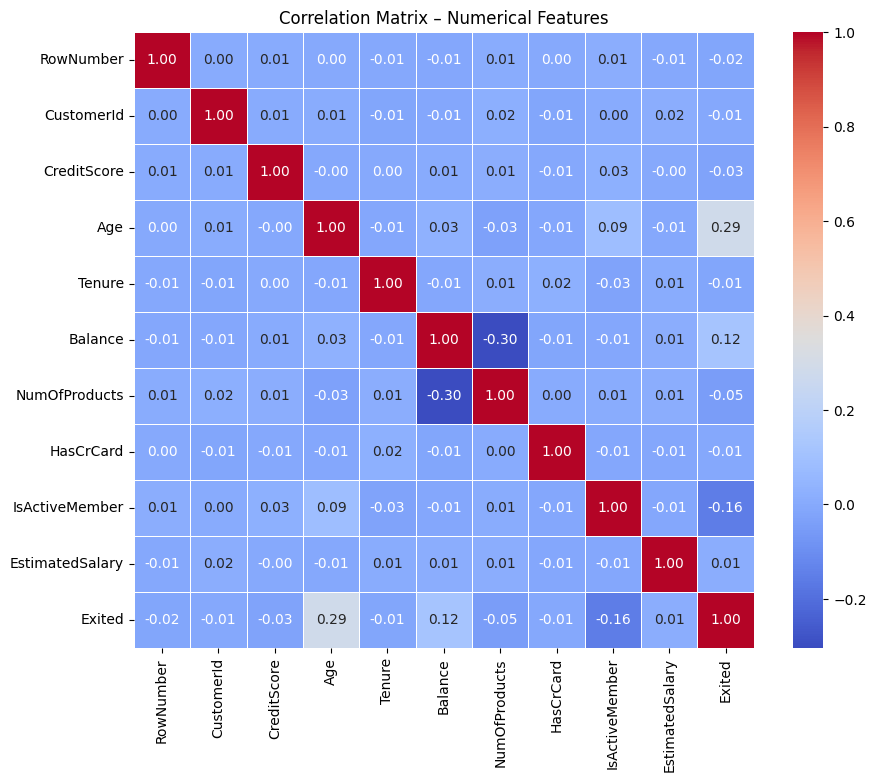

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar solo las variables numéricas
numerical_df = df.select_dtypes(include=['int64', 'float64'])

# Calcular matriz de correlación
corr_matrix = numerical_df.corr()

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix – Numerical Features")
plt.show()

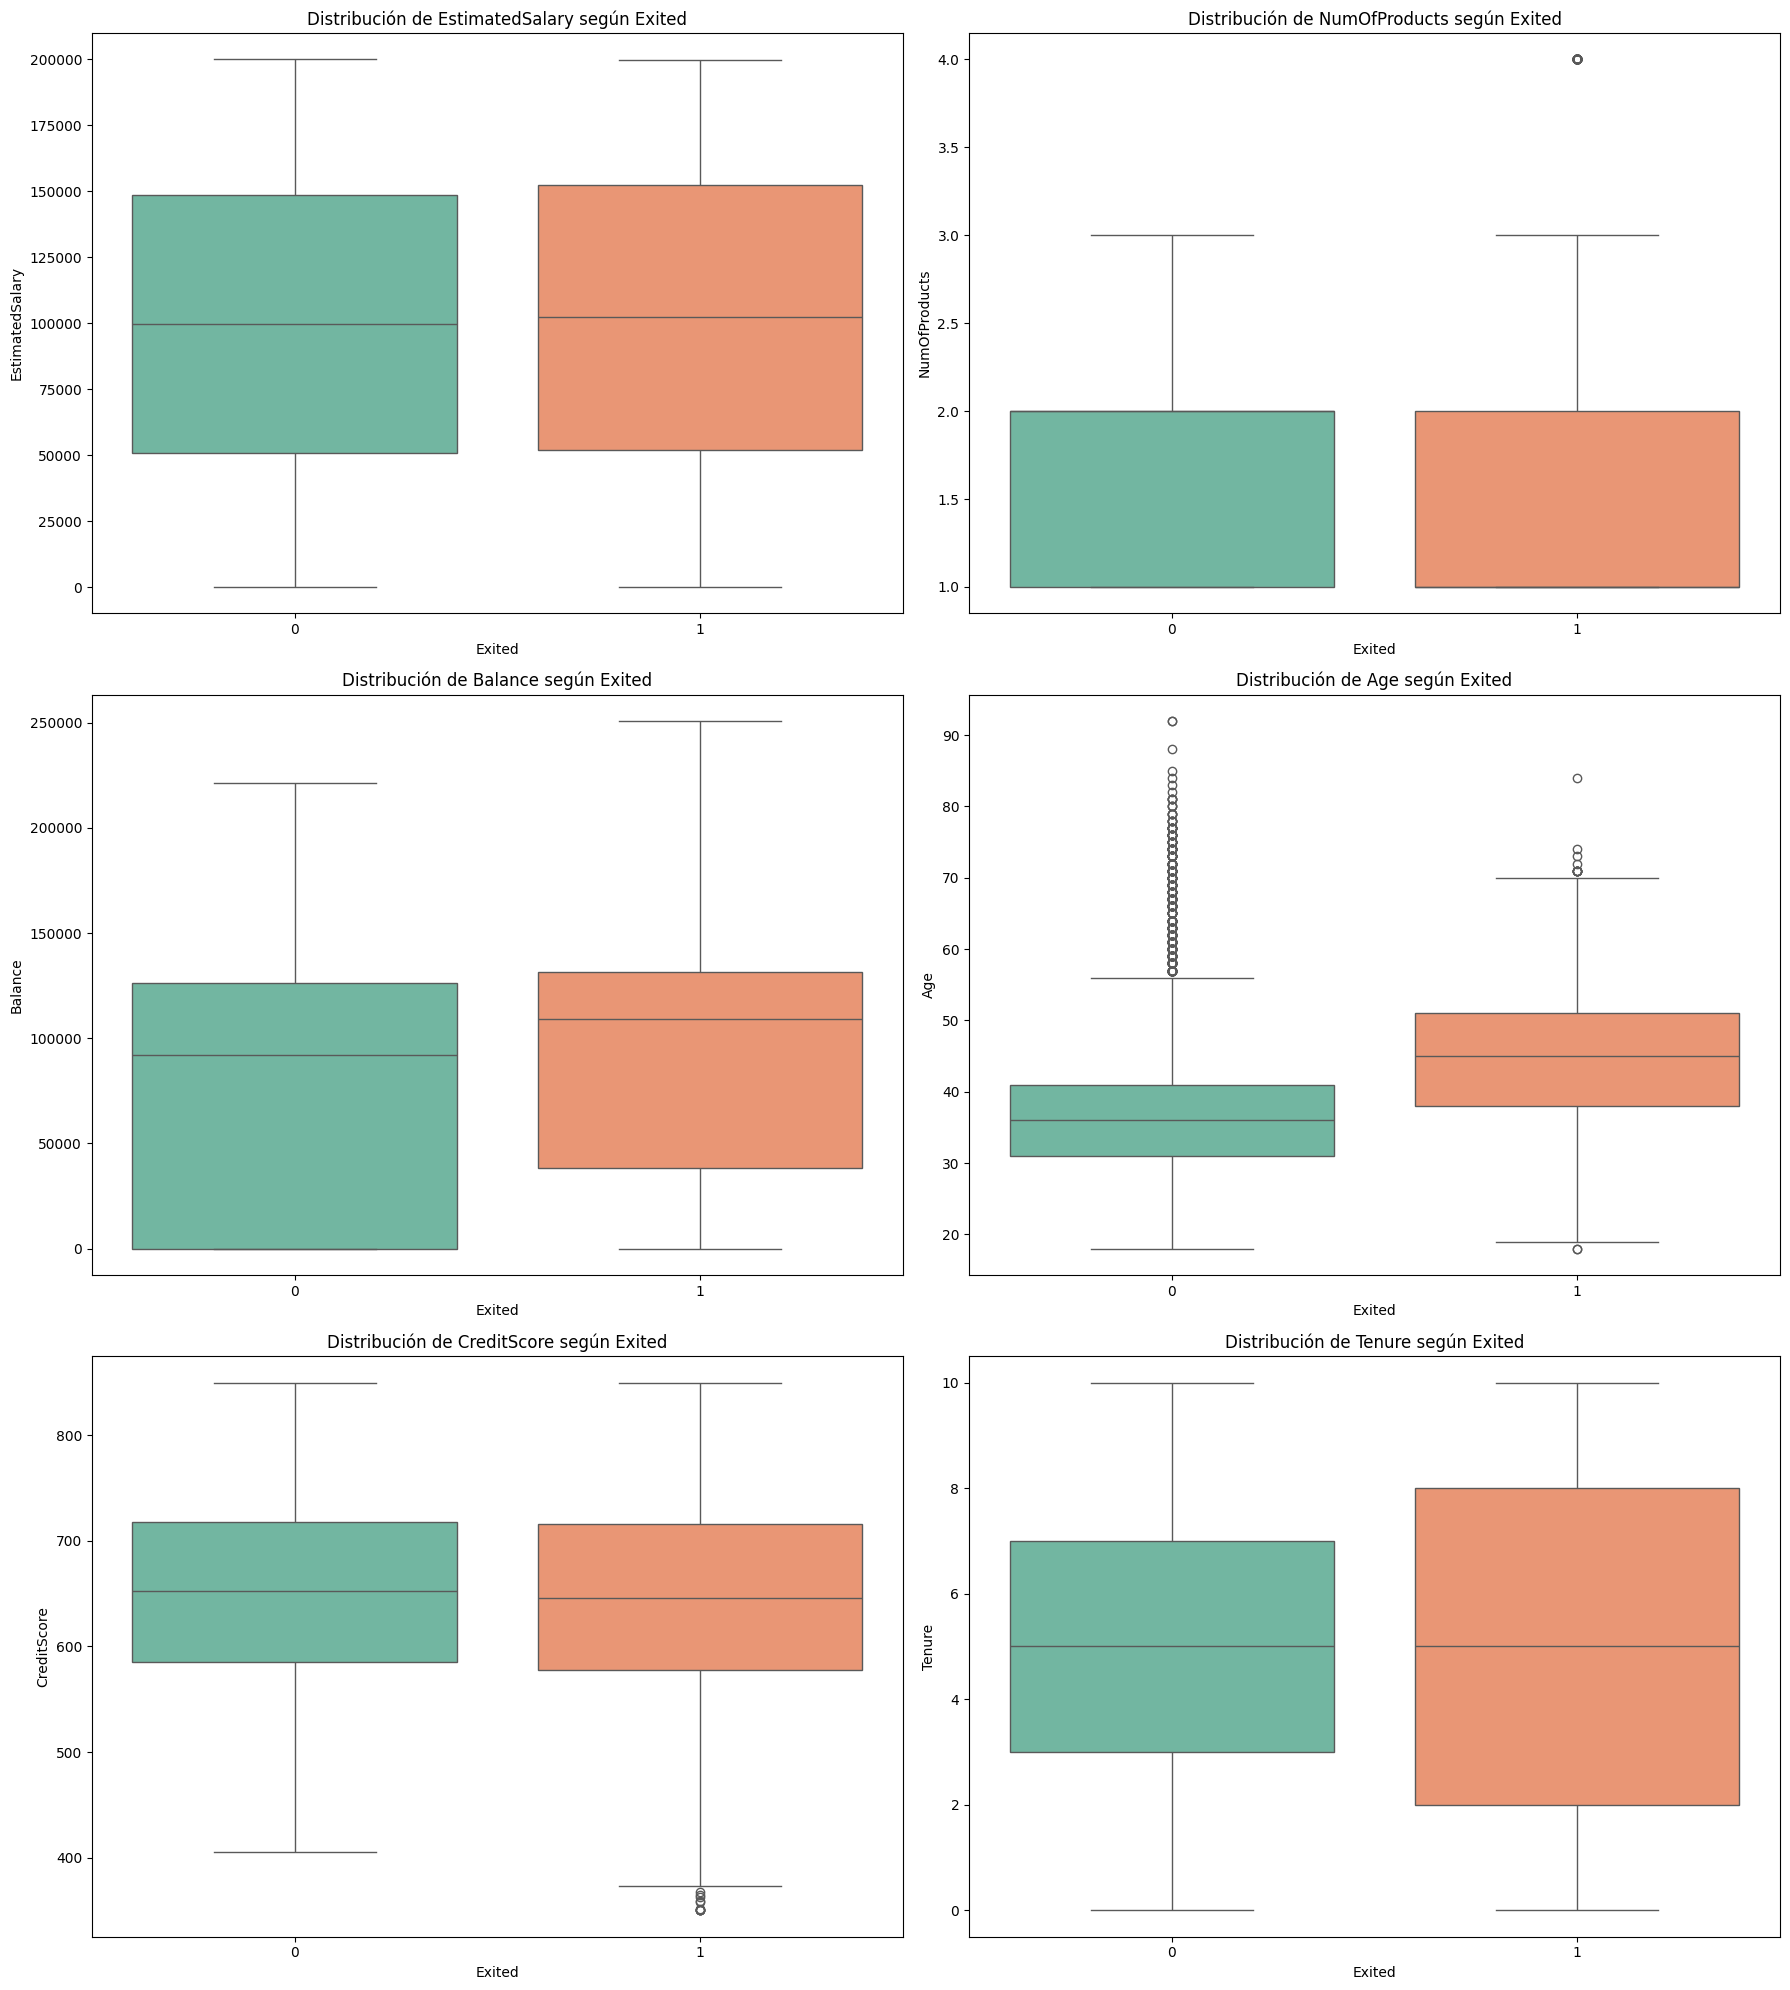

In [ ]:
variables_numericas = [ 'EstimatedSalary','NumOfProducts', 'Balance', 'Age', 'CreditScore','Tenure']

plt.figure(figsize=(18, 20))

for i, var in enumerate(variables_numericas):
    plt.subplot(3, 2, i+1)
    sns.boxplot(data=df, x='Exited', y=var, palette='Set2')
    plt.title(f'Distribución de {var} según Exited')
    plt.xlabel('Exited')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

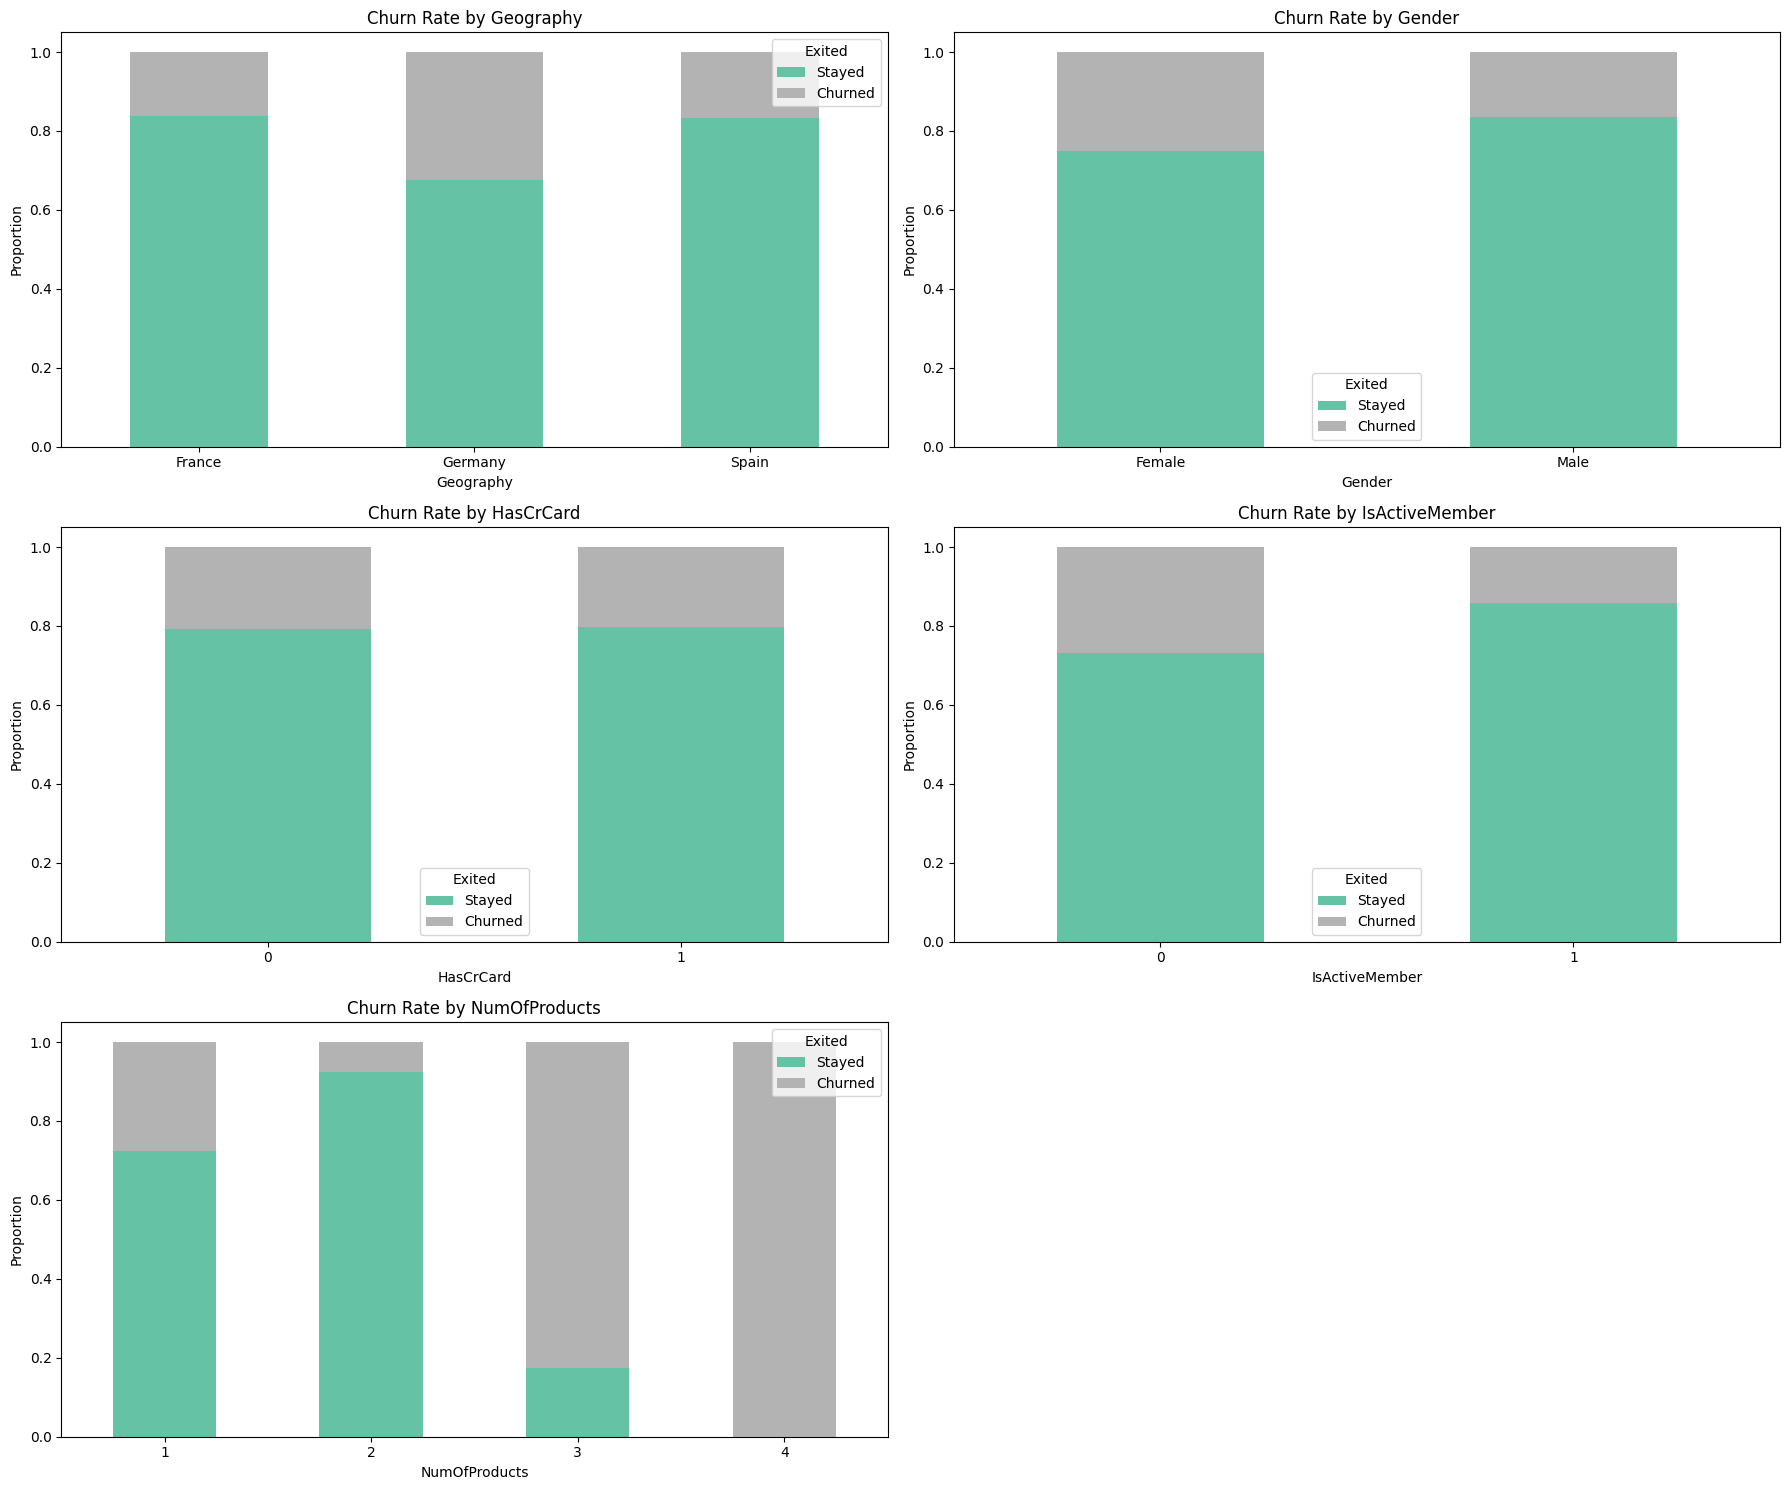

In [ ]:


categorical_vars = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']

plt.figure(figsize=(18, 15))

for i, var in enumerate(categorical_vars):
    plt.subplot(3, 2, i+1)
    prop_df = df.groupby(var)['Exited'].value_counts(normalize=True).unstack().fillna(0)
    prop_df.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Set2')
    plt.title(f'Churn Rate by {var}')
    plt.ylabel('Proportion')
    plt.xlabel(var)
    plt.xticks(rotation=0)
    plt.legend(title='Exited', labels=['Stayed', 'Churned'])

plt.tight_layout()
plt.show()

### Insight sobre Exited (Churn)

• **Distribución desequilibrada:** Aproximadamente el 20% de los clientes han abandonado el banco, mientras que el 80% permanecen activos. Esto evidencia un claro desbalance de clases, lo cual deberá ser abordado en el modelado mediante técnicas como ajuste del umbral de decisión, uso de métricas robustas (AUC, Lift, F1), o métodos de resampling como **SMOTE** o **undersampling**.

• **Relación con Balance:** Los clientes que abandonaron el banco (`Exited = 1`) presentan en promedio un balance mayor que los que permanecieron. Esto sugiere que **clientes potencialmente valiosos también están en riesgo de churn**, lo cual representa una oportunidad crítica para campañas de retención personalizadas.

# 2. Data preparation


In [8]:
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

In [9]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [10]:
# Label encoding para Gender
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0}).astype(float)

# One-hot encoding para Geography (manteniendo todas las columnas)
df = pd.get_dummies(df, columns=['Geography'], drop_first=False)

# Asegurar que todas las variables dummy creadas también sean float
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(float)

In [ ]:
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,0.00,42,2,0.00,1,1,1,101348.88,1,1.00,0.00,0.00
1,608,0.00,41,1,83807.86,1,0,1,112542.58,0,0.00,0.00,1.00
2,502,0.00,42,8,159660.80,3,1,0,113931.57,1,1.00,0.00,0.00
3,699,0.00,39,1,0.00,2,0,0,93826.63,0,1.00,0.00,0.00
4,850,0.00,43,2,125510.82,1,1,1,79084.10,0,0.00,0.00,1.00


In [11]:
# Variable dependiente
y = df['Exited']

# Variables independientes: todas las demás columnas
X = df.drop(columns=['Exited'])

In [12]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Modelling

## 3.1. Logistic Regression

In [13]:
logit_model = LogisticRegression(max_iter=1000, class_weight='balanced')
logit_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [14]:
from sklearn.metrics import roc_curve

# Obtener las probabilidades de clase positiva
y_prob = logit_model.predict_proba(X_test)[:, 1]

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calcular el índice de Youden
j_scores = tpr - fpr
optimal_idx = j_scores.argmax()
optimal_threshold = thresholds[optimal_idx]

print(f"Best threshold: {optimal_threshold:.3f}")

Best threshold: 0.544


In [15]:
# Predicciones ajustadas usando el nuevo umbral
y_pred_adj = (y_prob >= 0.543).astype(int)

# Evaluación
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(confusion_matrix(y_test, y_pred_adj))
print(classification_report(y_test, y_pred_adj))
print("AUC:", roc_auc_score(y_test, y_prob))

[[1214  379]
 [ 143  264]]
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1593
           1       0.41      0.65      0.50       407

    accuracy                           0.74      2000
   macro avg       0.65      0.71      0.66      2000
weighted avg       0.80      0.74      0.76      2000

AUC: 0.7693903456615321


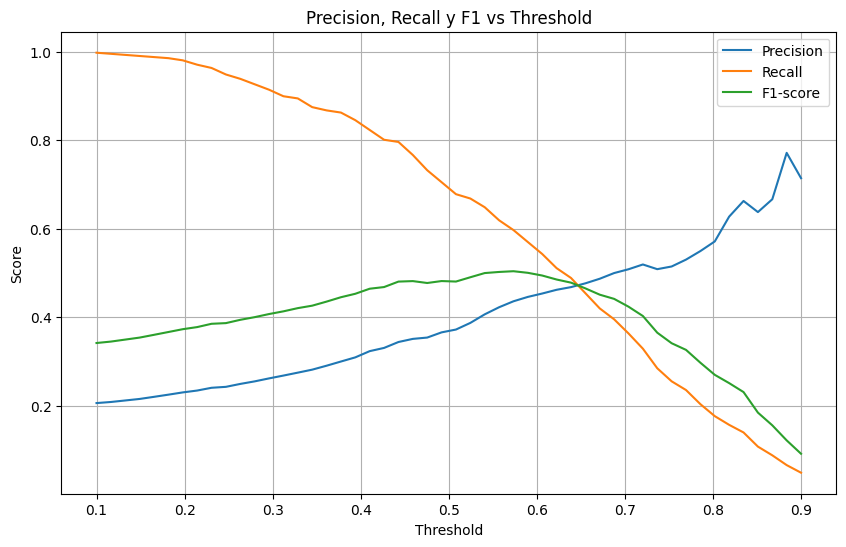

In [ ]:
thresholds = np.linspace(0.1, 0.9, 50)
precisions = []
recalls = []
f1_scores = []

for t in thresholds:
    y_pred_adj = (y_prob >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred_adj))
    recalls.append(recall_score(y_test, y_pred_adj))
    f1_scores.append(f1_score(y_test, y_pred_adj))

# Graficar
plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall y F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train)  # Le estás agregando una columna extra con puros unos al X_train. Esto es el intercepto del modelo (la constante β₀ que no depende de ninguna variable). Sin eso, el modelo no lo estima.#
#“Mi variable dependiente es y_train, y mis explicativas son X_train_sm.”
logit_sm = sm.Logit(y_train, X_train_sm)
#Esto entrena el modelo. Usa máxima verosimilitud para encontrar los coeficientes que mejor ajustan los datos.
result = logit_sm.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.429166
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Exited   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7988
Method:                           MLE   Df Model:                           11
Date:                Thu, 03 Jul 2025   Pseudo R-squ.:                  0.1511
Time:                        00:45:21   Log-Likelihood:                -3433.3
converged:                       True   LL-Null:                       -4044.5
Covariance Type:            nonrobust   LLR p-value:                2.584e-255
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -3.2109      0.273    -11.775      0.000      -3.745      -2.676
CreditSc

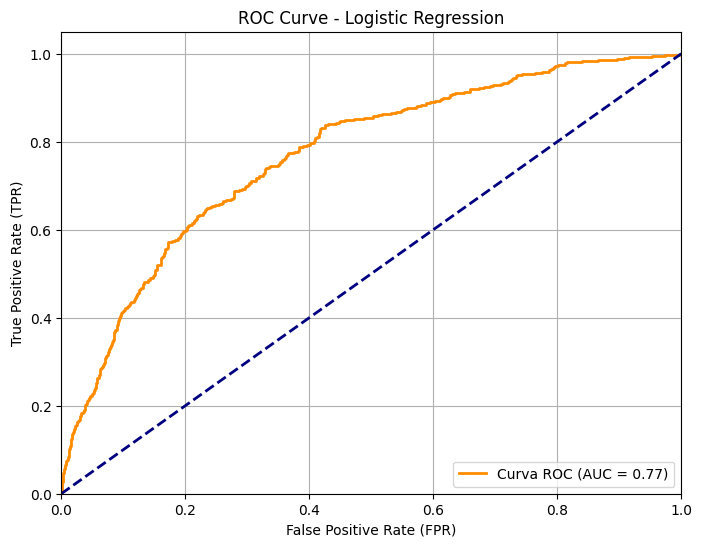

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtener los valores de FPR (false positive rate), TPR (true positive rate) y umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calcular el área bajo la curva
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # línea de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

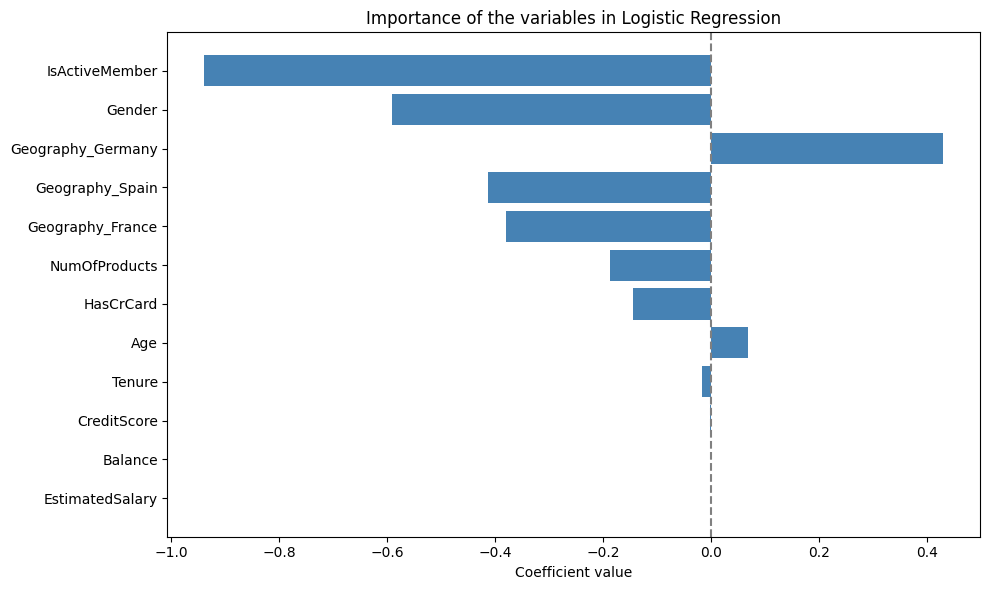

In [20]:
coef_df = pd.DataFrame({
    'Variable': X_train.columns,
    'Coeficiente': logit_model.coef_[0]
})

# Ordenar por valor absoluto del coeficiente
coef_df['Importancia'] = np.abs(coef_df['Coeficiente'])
coef_df = coef_df.sort_values(by='Importancia', ascending=True)

# Gráfico
plt.figure(figsize=(10,6))
plt.barh(coef_df['Variable'], coef_df['Coeficiente'], color='steelblue')
plt.axvline(x=0, color='gray', linestyle='--')
plt.title('Importance of the variables in Logistic Regression')
plt.xlabel('Coefficient value')
plt.tight_layout()
plt.show()

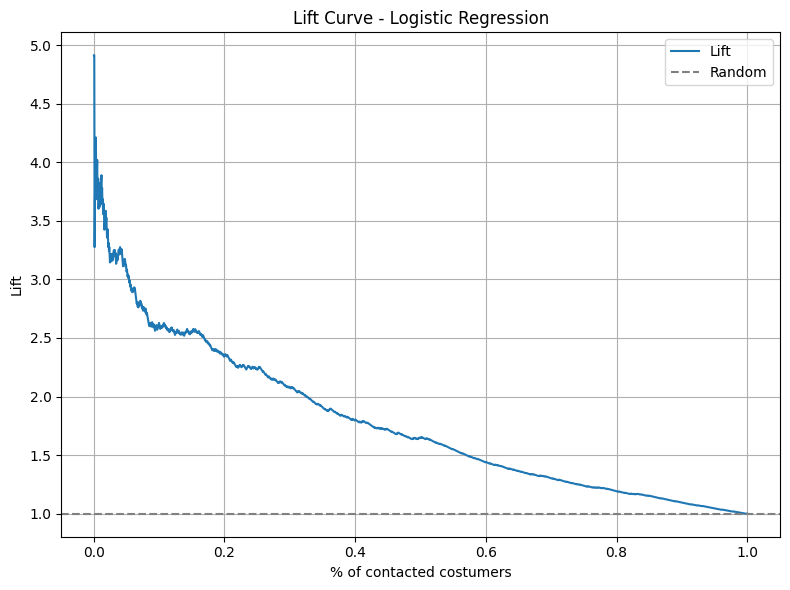

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def plot_lift_curve(y_true, y_scores, title='Lift Curve'):
    """
    Grafica la curva de Lift: mide cuánto mejora el modelo en comparación al azar
    para identificar eventos positivos (como churn).
    """
    # Ordenar por probabilidad
    data = list(zip(y_true, y_scores))
    data.sort(key=lambda x: x[1], reverse=True)
    y_sorted = [x[0] for x in data]

    total_positives = sum(y_sorted)
    pctg_positives = []
    pctg_samples = []

    for i in range(1, len(y_sorted) + 1):
        pctg_samples.append(i / len(y_sorted))
        pctg_positives.append(sum(y_sorted[:i]) / total_positives)

    lift = np.array(pctg_positives) / np.array(pctg_samples)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(pctg_samples, lift, label='Lift')
    plt.axhline(y=1, color='gray', linestyle='--', label='Random')
    plt.xlabel('% of contacted costumers')
    plt.ylabel('Lift')
    plt.title('Lift Curve - Logistic Regression')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_lift_curve(y_test, y_prob)

## Second Model - Classification Tree

In [21]:
df = pd.read_csv('Churn_Modelling.csv')
# Label encoding para Gender
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0}).astype(float)

# One-hot encoding para Geography (manteniendo todas las columnas)
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)

# Asegurar que todas las variables dummy creadas también sean float
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(float)
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)


In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Train Model


tree_model = DecisionTreeClassifier( random_state=42,class_weight = 'balanced')
tree_model.fit(X_train, y_train)

y_pred_tree = tree_model.predict(X_test)
y_prob_tree = tree_model.predict_proba(X_test)[:, 1]


# 3. Evaluation
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))
print("AUC:", roc_auc_score(y_test, y_prob_tree))

[[1359  234]
 [ 217  190]]
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1593
           1       0.45      0.47      0.46       407

    accuracy                           0.77      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.78      0.77      0.78      2000

AUC: 0.6599689057316176


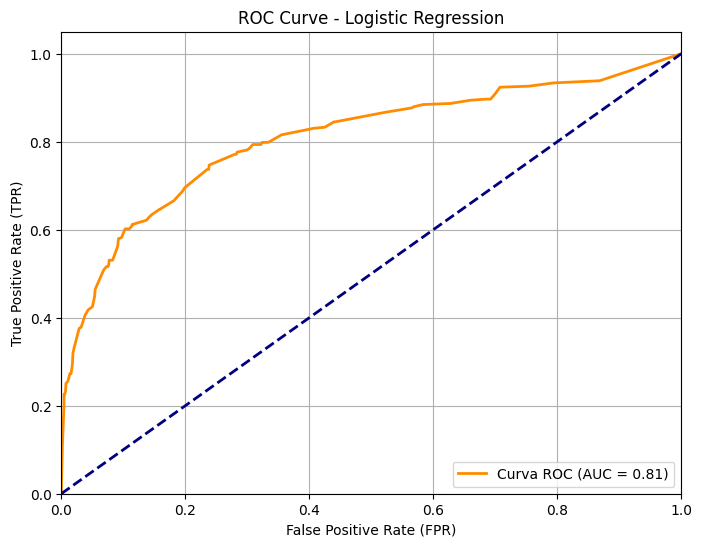

In [41]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtener los valores de FPR (false positive rate), TPR (true positive rate) y umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calcular el área bajo la curva
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # línea de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Adjusting Hyper-parameters

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_features': [None, 'sqrt', 'log2']
}

tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'max_depth': 8, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 10}


In [34]:
import numpy as np
from sklearn.metrics import f1_score

y_prob_tree = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.0, 1.01, 0.01)

f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_prob_tree >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)

best_thresh = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Mejor umbral: {best_thresh}")
print(f"Mejor F1-score: {best_f1}")

Mejor umbral: 0.64
Mejor F1-score: 0.6004901960784313


In [31]:
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
# Clasificación final con el nuevo umbral
y_pred_final = (y_prob >= 0.64).astype(int)

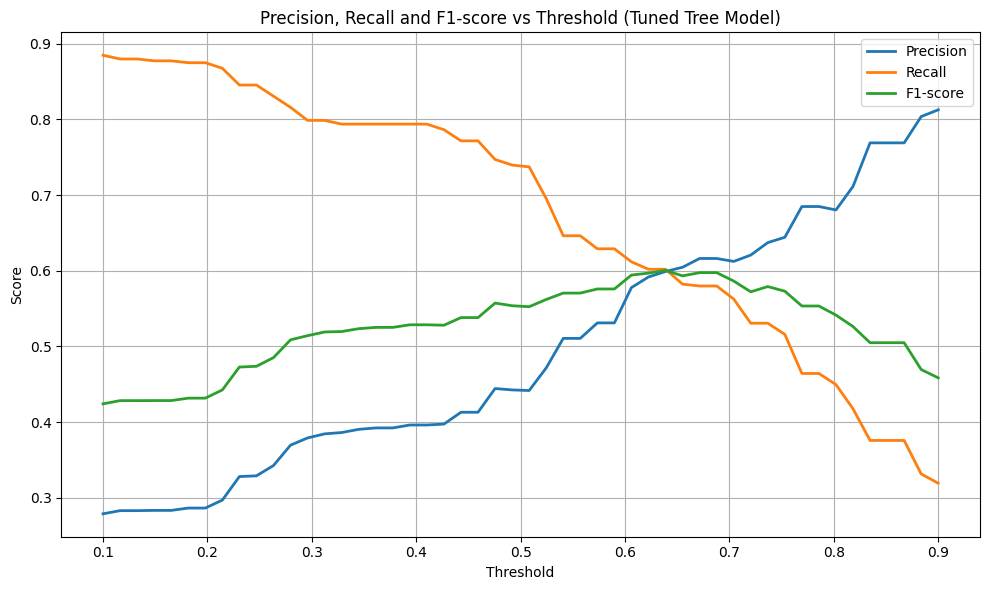

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0.1, 0.9, 50)

precisions = []
recalls = []
f1_scores = []

for t in thresholds:
    y_pred_adj = (y_prob >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred_adj))
    recalls.append(recall_score(y_test, y_pred_adj))
    f1_scores.append(f1_score(y_test, y_pred_adj))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.plot(thresholds, f1_scores, label='F1-score', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall and F1-score vs Threshold (Tuned Tree Model)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Adjusted Tree - Evaluation

In [40]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred_final = (y_prob >= 0.64).astype(int)

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_final))

print("\n Classification Report:")
print(classification_report(y_test, y_pred_final))



Matriz de Confusión:
[[1429  164]
 [ 162  245]]

 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1593
           1       0.60      0.60      0.60       407

    accuracy                           0.84      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.84      0.84      0.84      2000



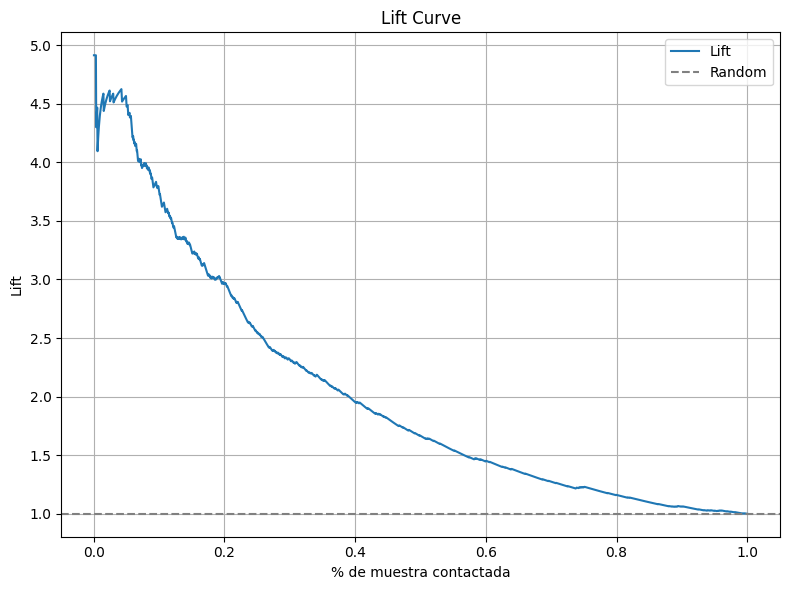

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def plot_lift_curve(y_true, y_scores, title='Lift Curve'):
    """
    Grafica la curva de Lift: mide cuánto mejora el modelo en comparación al azar
    para identificar eventos positivos (como churn).
    """
    # Ordenar por probabilidad
    data = list(zip(y_true, y_scores))
    data.sort(key=lambda x: x[1], reverse=True)
    y_sorted = [x[0] for x in data]

    total_positives = sum(y_sorted)
    pctg_positives = []
    pctg_samples = []

    for i in range(1, len(y_sorted) + 1):
        pctg_samples.append(i / len(y_sorted))
        pctg_positives.append(sum(y_sorted[:i]) / total_positives)

    lift = np.array(pctg_positives) / np.array(pctg_samples)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(pctg_samples, lift, label='Lift')
    plt.axhline(y=1, color='gray', linestyle='--', label='Random')
    plt.xlabel('% de muestra contactada')
    plt.ylabel('Lift')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_lift_curve(y_test, y_prob)

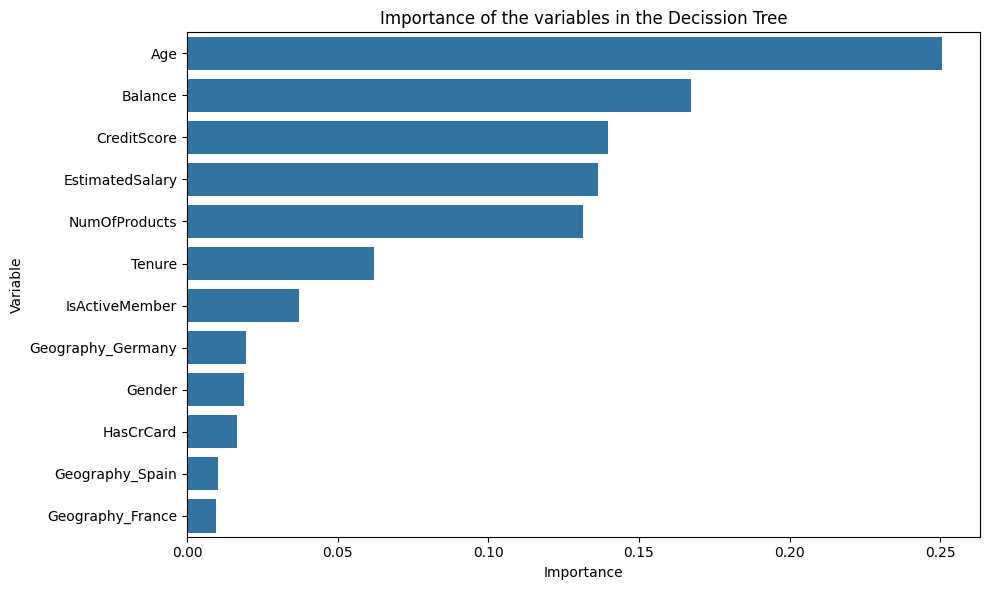

In [42]:
importances = tree_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features, order=features[np.argsort(importances)[::-1]])
plt.title("Importance of the variables in the Decission Tree")
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.tight_layout()

plt.show()

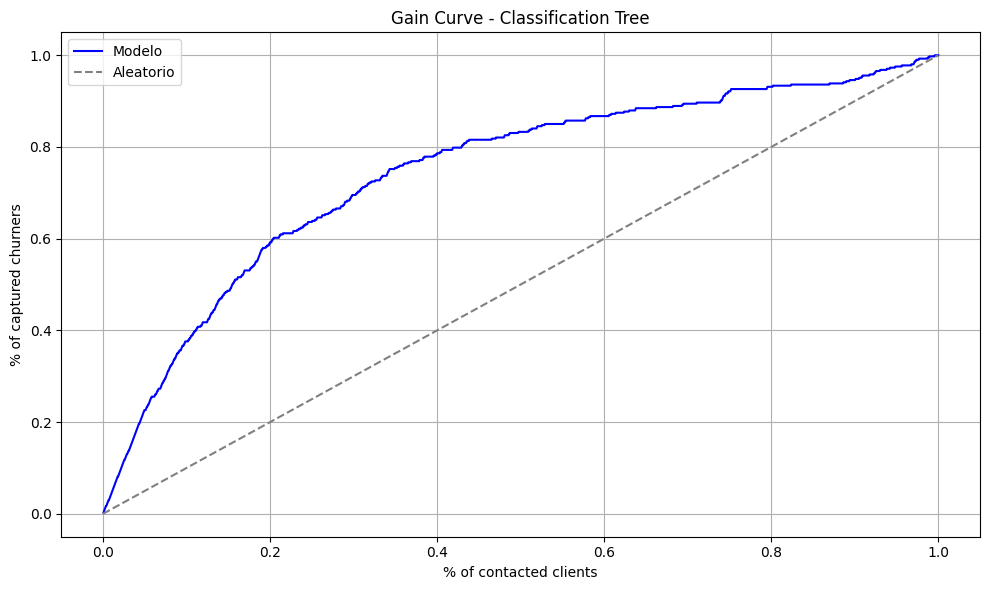

In [46]:
import numpy as np
import matplotlib.pyplot as plt

y_test_array = y_test.reset_index(drop=True)
y_prob_array = pd.Series(y_prob).reset_index(drop=True)

indices = np.argsort(y_prob_array)[::-1]
y_true_sorted = y_test_array.iloc[indices].values

cumulative_gains = np.cumsum(y_true_sorted)
total_positives = cumulative_gains[-1]
percentage_of_customers = np.arange(1, len(y_true_sorted)+1) / len(y_true_sorted)
gain = cumulative_gains / total_positives

plt.figure(figsize=(10, 6))
plt.plot(percentage_of_customers, gain, label='Modelo', color='blue')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Aleatorio')
plt.xlabel('% of contacted clients')
plt.ylabel('% of captured churners')
plt.title('Gain Curve - Classification Tree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

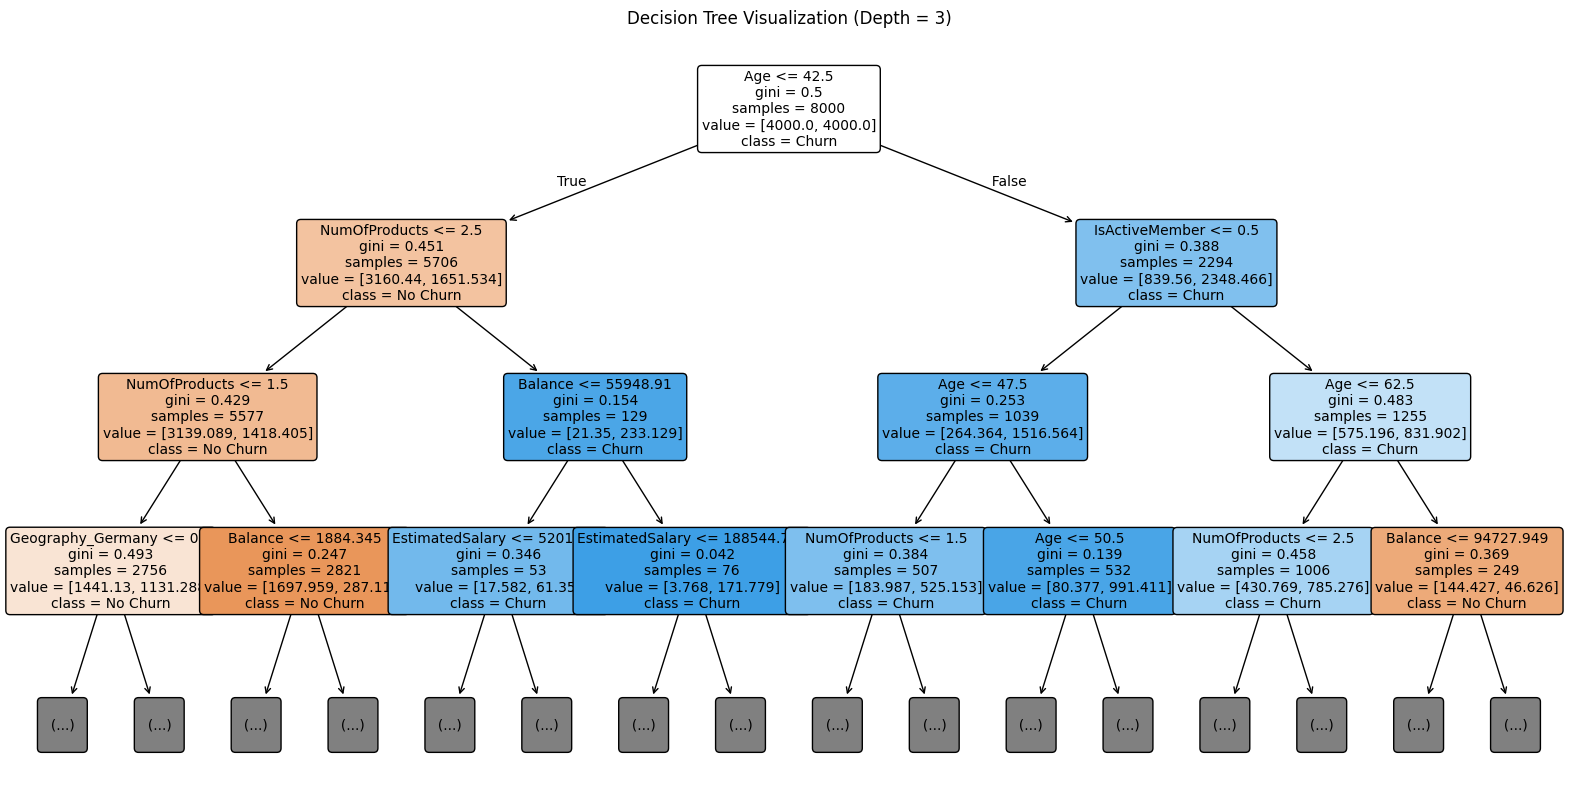

In [47]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(grid_search.best_estimator_,
          feature_names=X_train.columns,
          class_names=["No Churn", "Churn"],
          filled=True,
          rounded=True,
          max_depth=3,  # limitar visualización para que no sea ilegible
          fontsize=10)
plt.title("Decision Tree Visualization (Depth = 3)")
plt.show()

In [48]:
from sklearn.tree import export_text

tree_rules = export_text(grid_search.best_estimator_,
                         feature_names=list(X_train.columns),
                         max_depth=3)  # también puedes limitar aquí

print(tree_rules)

|--- Age <= 42.50
|   |--- NumOfProducts <= 2.50
|   |   |--- NumOfProducts <= 1.50
|   |   |   |--- Geography_Germany <= 0.50
|   |   |   |   |--- truncated branch of depth 5
|   |   |   |--- Geography_Germany >  0.50
|   |   |   |   |--- truncated branch of depth 5
|   |   |--- NumOfProducts >  1.50
|   |   |   |--- Balance <= 1884.34
|   |   |   |   |--- truncated branch of depth 5
|   |   |   |--- Balance >  1884.34
|   |   |   |   |--- truncated branch of depth 5
|   |--- NumOfProducts >  2.50
|   |   |--- Balance <= 55948.91
|   |   |   |--- EstimatedSalary <= 52014.92
|   |   |   |   |--- class: 0
|   |   |   |--- EstimatedSalary >  52014.92
|   |   |   |   |--- truncated branch of depth 5
|   |   |--- Balance >  55948.91
|   |   |   |--- EstimatedSalary <= 188544.70
|   |   |   |   |--- truncated branch of depth 5
|   |   |   |--- EstimatedSalary >  188544.70
|   |   |   |   |--- class: 1
|--- Age >  42.50
|   |--- IsActiveMember <= 0.50
|   |   |--- Age <= 47.50
|   |   |   |-

Insights Finales – Comparación de Modelos

Árbol de Decisión (con hiperparámetros ajustados)
	•	Mejor desempeño global:
	•	F1-score para la clase Churn (Exited = 1): 0.56
	•	Recall: 0.74
	•	AUC: 0.81
	•	Supera al modelo logístico especialmente en recall y AUC, lo cual es clave si el objetivo del negocio es detectar a la mayor cantidad de clientes en riesgo.
	•	Principales variables según importancia:
	•	Age, Balance, EstimatedSalary, CreditScore y NumOfProducts fueron las variables más relevantes.
	•	Age fue la variable que más dividió el árbol, indicando su fuerte asociación con el riesgo de abandono.
	•	IsActiveMember, aunque fuerte en el modelo logístico, tiene menor peso relativo en el árbol.


# XG BOOST MODEL

In [49]:
import xgboost as xgb

In [50]:
df = pd.read_csv('Churn_Modelling.csv')

# Label encoding para Gender
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0}).astype(float)

# One-hot encoding para Geography (sin eliminar ninguna categoría si deseas interpretabilidad completa)
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)

# Asegurar que todas las variables dummy sean float
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(float)

# Eliminar columnas no relevantes
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

In [51]:
from sklearn.model_selection import train_test_split

X = df.drop('Exited', axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [53]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=(len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))

[[1393  200]
 [ 155  252]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      1593
           1       0.56      0.62      0.59       407

    accuracy                           0.82      2000
   macro avg       0.73      0.75      0.74      2000
weighted avg       0.83      0.82      0.83      2000

AUC: 0.8357602594890731


### XGBOOST Tuning


In [56]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


New model:

In [62]:
xgb_best = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=(len(y_train[y_train == 0]) / len(y_train[y_train == 1])),
    n_estimators=100,
    max_depth=7,
    learning_rate=0.1,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb_best.fit(X_train, y_train)
y_prob = xgb_best.predict_proba(X_test)[:, 1]

Best threshold

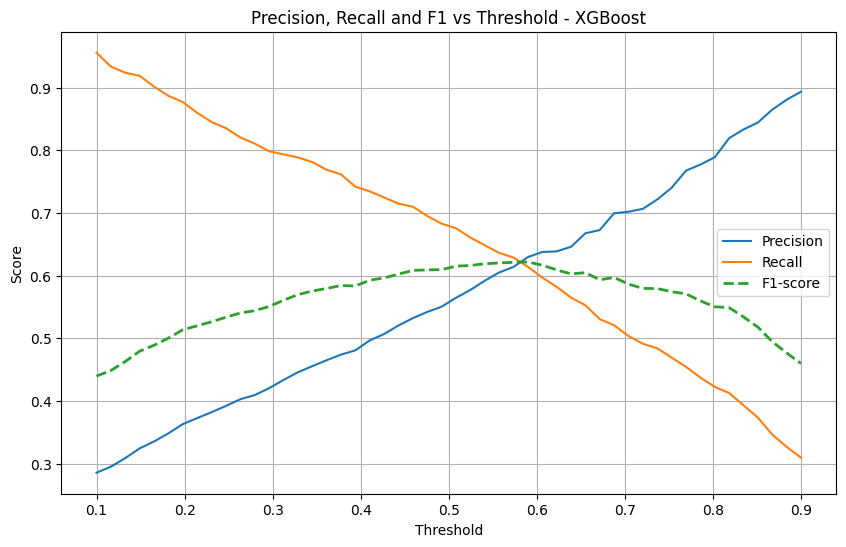

Best threshold by F1-score: 0.590


In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0.1, 0.9, 50)
precisions = []
recalls = []
f1_scores = []

for t in thresholds:
    y_pred_adj = (y_prob >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred_adj))
    recalls.append(recall_score(y_test, y_pred_adj))
    f1_scores.append(f1_score(y_test, y_pred_adj))

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-score', linewidth=2, linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall and F1 vs Threshold - XGBoost')
plt.legend()
plt.grid(True)
plt.show()

# Encontrar el mejor threshold (máximo F1)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best threshold by F1-score: {best_threshold:.3f}")

In [68]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Clasificación final con el umbral óptimo
y_pred_opt = (y_prob >= 0.59).astype(int)

# Matriz de confusión
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_opt))

# Reporte de clasificación
print("\nClassification Report:")
print(classification_report(y_test, y_pred_opt))

# AUC-ROC
print(f"AUC: {roc_auc_score(y_test, y_prob):.4f}")

🔍 Confusion Matrix:
[[1446  147]
 [ 157  250]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1593
           1       0.63      0.61      0.62       407

    accuracy                           0.85      2000
   macro avg       0.77      0.76      0.76      2000
weighted avg       0.85      0.85      0.85      2000

AUC: 0.8537


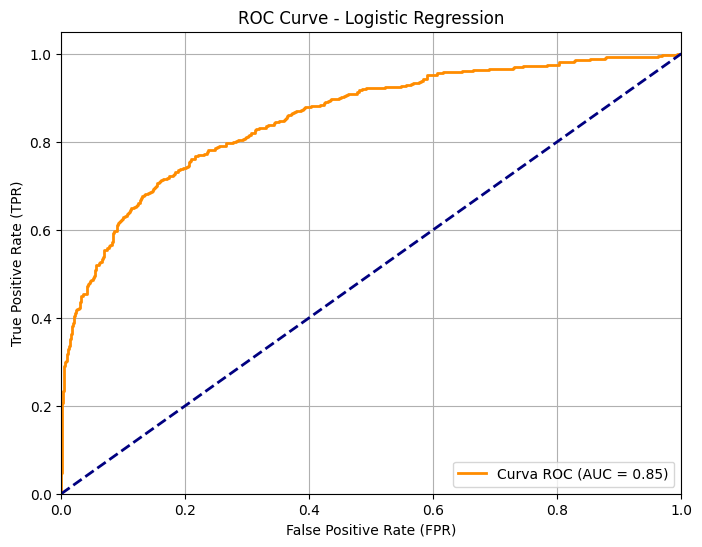

In [70]:

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # línea de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

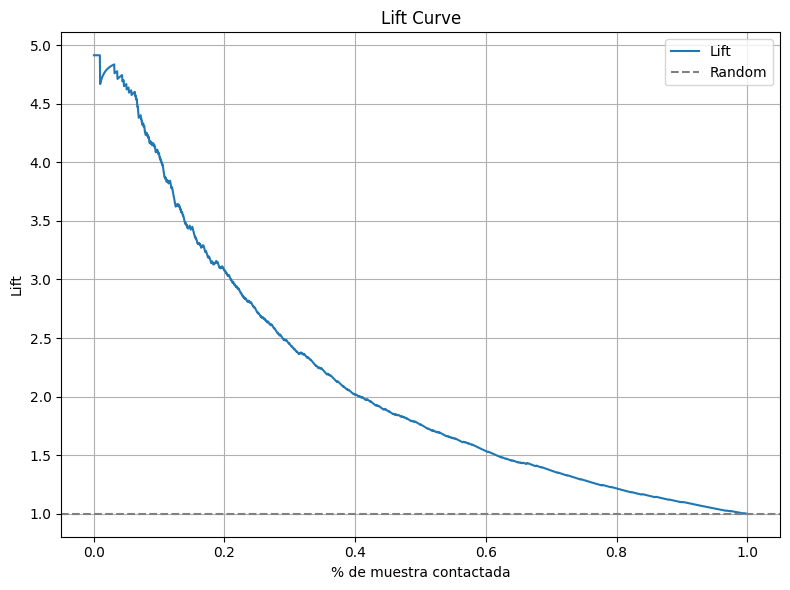

In [71]:
plot_lift_curve(y_test, y_prob)

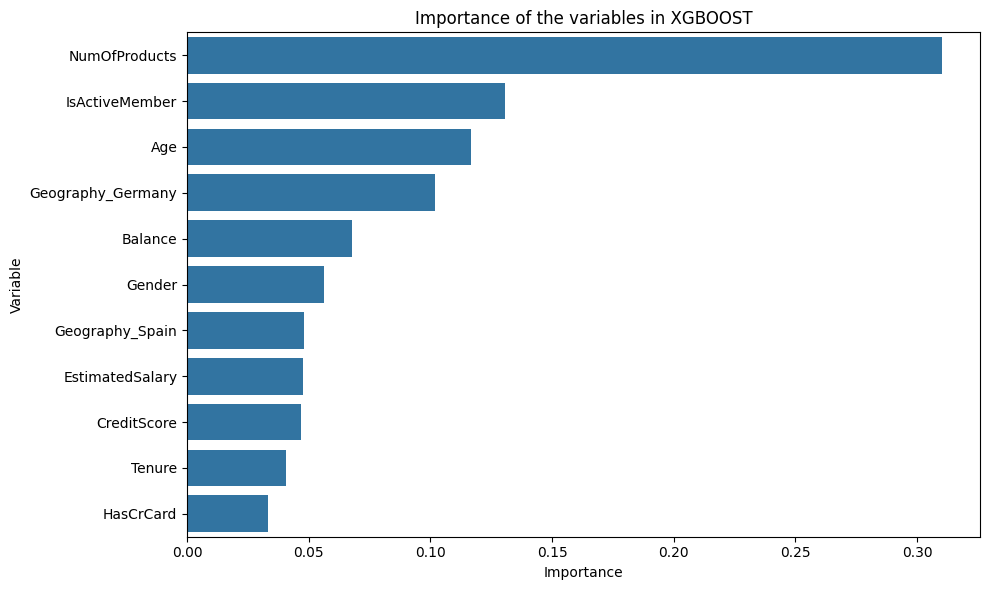

In [75]:
importances = xgb_best.feature_importances_
features = X_train.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features, order=features[np.argsort(importances)[::-1]])
plt.title("Importance of the variables in XGBOOST")
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.tight_layout()

plt.show()

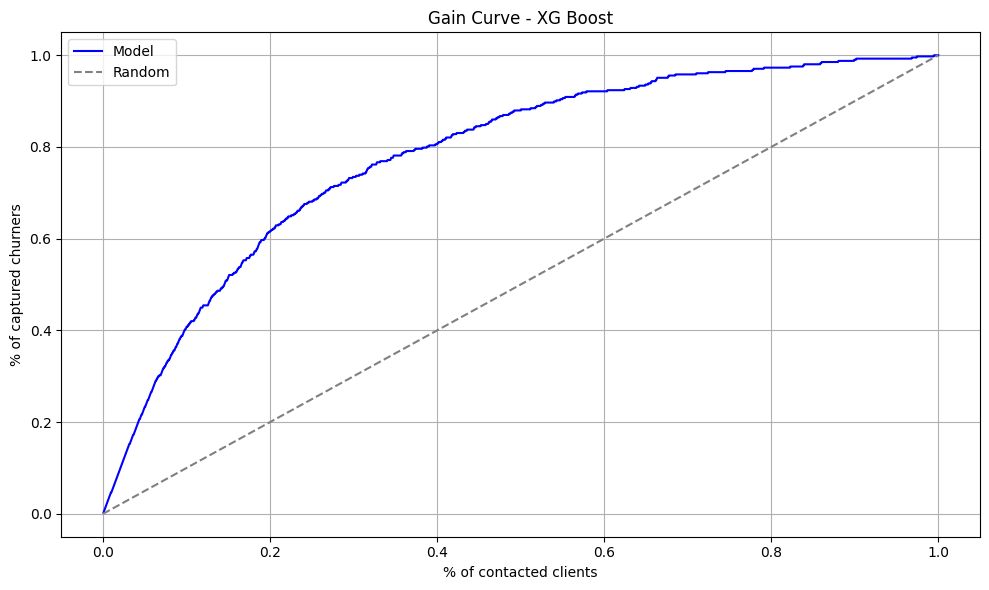

In [79]:
y_prob = xgb_best.predict_proba(X_test)[:, 1]
y_test_array = y_test.reset_index(drop=True)
y_prob_array = pd.Series(y_prob).reset_index(drop=True)

indices = np.argsort(y_prob_array)[::-1]
y_true_sorted = y_test_array.iloc[indices].values

cumulative_gains = np.cumsum(y_true_sorted)
total_positives = cumulative_gains[-1]
percentage_of_customers = np.arange(1, len(y_true_sorted)+1) / len(y_true_sorted)
gain = cumulative_gains / total_positives

plt.figure(figsize=(10, 6))
plt.plot(percentage_of_customers, gain, label='Model', color='blue')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
plt.xlabel('% of contacted clients')
plt.ylabel('% of captured churners')
plt.title('Gain Curve - XG Boost')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

Images/Gain Cruve - XGBoost.png